In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import os
import numpy as np
import seaborn as sns

In [30]:
import sys
#plib = $path
sys.path.append(plib)
import Raman_preprocess as Raman, Raman_find_polymer as rfp, Raman_read
import imp
imp.reload(rfp)

<module 'Raman_find_polymer' from '/Users/zijianleowang/Desktop/GitHub/RamanomeSpec/scripts/Raman_find_polymer.py'>

In [19]:
raw_Raman = r'/$PATH/PAO-Raman.csv'
df1 = pd.read_csv(raw_Raman).drop(0).T.iloc[:-1,:].astype(np.float)
wn = df1.iloc[0,:] # wavenumber
BG = df1.iloc[[1],:] # BG
X = df1.iloc[2:,:] # feature nxd
X = pd.DataFrame(np.subtract(X.values,BG.values)) # BG subtraction
X = Raman.smooth(X)# smoothing
X = Raman.baseline(X.T).T# baseline correction
X.reset_index(inplace=True,drop=True) # reset index
Xmean = X.mean()
Xstd = X.std()


In [20]:
sample1 = X.iloc[0,:]
from scipy import signal
Xid = []
Xpeak = []
Ypeak = []
for i in range(X.shape[0]):
    samplei = X.iloc[i,:]
    peakind = signal.find_peaks_cwt(samplei, np.arange(1,10))
    Xi = wn[peakind]
    Yi = samplei[peakind]
    if (np.logical_and(Xi>1160,Xi<1190)).any() and not (samplei>40).any():
        id2 = np.logical_and(Xi>1150,Xi<1200) # selected id2 for polyP
        ypeak = samplei[peakind[id2]].tolist()[0]
        if ypeak>0.5:
            Xpeak.append(wn[peakind[id2]].tolist()[0])
            Ypeak.append(ypeak)
            Xid.append(i)
X2 = X.iloc[Xid,:]

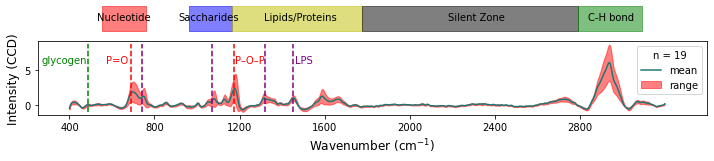

In [171]:

xlim = (300,3400)
ylim = (0,5)
fig1, ax1p = plt.subplots(2,1,figsize=(12,2),gridspec_kw={'height_ratios': [1, 3]})
ax0 = ax1p[0]
ax0.set_xticks([])
ax0.set_yticks([])
ax0.set_xlim(xlim)
ax0.set_ylim(ylim)
for i in ['right','left','top','bottom']:
    ax0.spines[i].set_visible(False)
def xrange(x,xp, y,name,c):
    ax0.fill_between(x,ylim[0],ylim[1],color=c,alpha=0.5)
    ax0.text(xp,y*0.9,name) # np.mean(x)
for tempx,tempx2,tempy,name,c in [[(600,800),575,np.mean(ylim),"Nucleotide",'r'],
                     [(1000,1200),950,np.mean(ylim),"Saccharides",'b'],
                     [(1200,1800),1350,np.mean(ylim),"Lipids/Proteins",'y'],
                     [(1800,2800),2200,np.mean(ylim),"Silent Zone",'k'],
                     [(2800,3100),2850,np.mean(ylim),"C-H bond",'g']
                                 ]:
    xrange(tempx,tempx2,tempy, name,c)


ax1 = ax1p[1]
ax1.plot(wn,X2.mean(),c='#1D7874',label='mean')
low, high = X2.mean()-X2.std(), X2.mean()+X2.std()
ax1.fill_between(wn,low,high,color='r',alpha=0.5,label='range')
ax1.set_xticks(np.arange(min(wn),max(wn),400))
ax1.set_xlabel("Wavenumber (cm$^{-1}$)",fontsize='large')
ax1.set_ylabel("Intensity (CCD)",fontsize='large')
ax1.vlines(1172,min(low),max(high),linestyle='--',color='r')
ax1.vlines(690,min(low),max(high),linestyle='--',color='r')
ax1.vlines(485,min(low),max(high),linestyle='--',color='g')

# Lipopolysaccharide: lipid A, inner core, outer core, O antigen
ax1.vlines(740,min(low),max(high),linestyle='--',color='purple') # lipid A symmetric v(CH_3)_3
ax1.vlines(1320,min(low),max(high),linestyle='--',color='purple') # O-Antigen core
ax1.vlines(1070,min(low),max(high),linestyle='--',color='purple') # O-Antigen core
ax1.vlines(1450,min(low),max(high),linestyle='--',color='purple') # lipid A



ax1.text(1180,6,'P–O–P',color="r")
ax1.text(570,6,'P=O',color="r")
ax1.text(270,6,'glycogen',color="g")
ax1.text(1460,6,'LPS',color="purple")

ax1.set_xlim(xlim[0]-50,xlim[1])
ax1.legend(title='n = {}'.format(X2.shape[0]))
fig1.savefig('/Users/zijianleowang/Desktop/Projects_in_Cornell/RACE/Raman.png',bbox_inches='tight',quality=300)
plt.show()

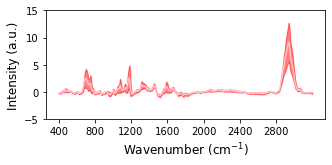

In [7]:
fig1, ax1 = plt.subplots(1,1,figsize=(5,2))
ax1.plot(wn,X2.mean(),c='pink',label='mean')
low, high = X2.mean()-X2.std(), X2.mean()+X2.std()
ax1.fill_between(wn,low,high,color='r',alpha=0.5,label='range')
ax1.set_xticks(np.arange(min(wn),max(wn),400))
ax1.set_xlabel("Wavenumber (cm$^{-1}$)",fontsize='large')
ax1.set_ylabel("Intensity (a.u.)",fontsize='large')
ax1.set_ylim((-5,15))
plt.show()

In [147]:
# load polyP in typical PAOs
df_typical = pd.read_csv("/Users/zijianleowang/Desktop/Projects_in_Cornell/RACE/PolyP_AT/polyP.csv",index_col=0)
df_typical.reset_index(inplace=True,drop=True)
df_typical = df_typical.sort_index(axis=1)
average = df_typical.mean(axis=0)

df_all = pd.concat([df_typical,
           pd.Series(Ypeak,name="PAOs")],axis=1) *20*(83.7/4/2)

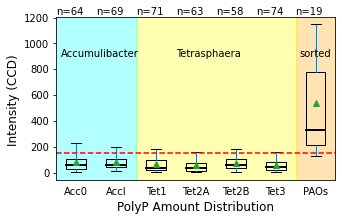

In [151]:
boxprops = dict(linestyle='-', linewidth=1, color='k')
medianprops = dict(linestyle='-', linewidth=2, color='k')
fig, ax = plt.subplots(1,1,figsize=(5,3))
bp = df_all.boxplot(grid=False,
                    showfliers=False, showmeans=True,
                    boxprops=boxprops, medianprops=medianprops, 
                    ax=ax, 
                    return_type='dict'
                    )
ax.set_ylabel("Wavenumber (cm$^{-1}$)",fontsize='large')
ax.set_xlabel("PolyP Amount Distribution",fontsize='large')
ax.set_ylabel("Intensity (CCD) ",fontsize='large')
ax.tick_params(bottom=False)
ylim = ax.get_ylim()
ax.fill_between([df_all.shape[1]-0.5,df_all.shape[1]+0.5],
                ylim[0],ylim[1],color="orange",alpha=.3)

ax.fill_between([df_all.shape[1]-0.5,2.5],
                ylim[0],ylim[1],color="yellow",alpha=.3)

ax.fill_between([0.5,2.5],
                ylim[0],ylim[1],color="cyan",alpha=.3)

ax.text(0.6,900, "Accumulibacter")
ax.text(3.5,900, "Tetrasphaera")
ax.text(6.6,900, "sorted")
ax.hlines(150,ax.get_xlim()[0],ax.get_xlim()[1],linestyles="--",color='r')
ax.set_ylim(ylim)

for i in range(df_all.shape[1]):
    ax.text(i+0.5,
            1220,
            "n=%i" % df_all.count().iloc[i])
fig.savefig('/Users/zijianleowang/Desktop/Projects_in_Cornell/RACE/polyP_AT.png',bbox_inches='tight',quality=300)


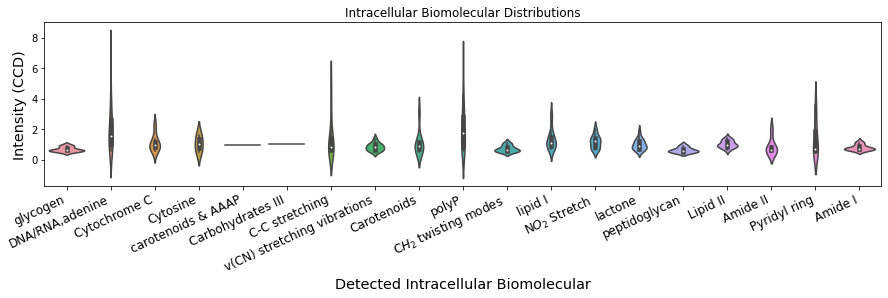

In [28]:
data2.to_csv("Biomol.violin.csv")
fig, ax = plt.subplots(1,1,figsize=(15,3))
ax = sns.violinplot(data=data2,ax=ax)
ax.set_xticklabels(ax.get_xticklabels(),rotation=25,ha='right',fontsize='large')
ax.set_ylabel('Intensity (CCD)',fontsize='x-large')
ax.set_xlabel("Detected Intracellular Biomolecular",fontsize='x-large')
ax.set_title("Intracellular Biomolecular Distributions",fontsize='large')
plt.show()
fig.savefig('Biomol.png',bbox_inches='tight',quality=300)

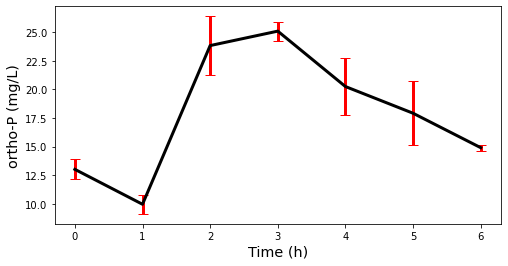

In [324]:
p_ortho = r'/Users/zijianleowang/Desktop/Projects_in_Cornell/RACE/ortho-P.xlsx'
df = pd.read_excel(p_ortho,sheet_name='plot')
time = df.iloc[:,0]
ave = df.iloc[:,1]
std = df.iloc[:,2]
fig = plt.figure(figsize=(8,4))
plt.errorbar(time,ave,std,color='k',lw=3,ecolor='r',capsize=5)
plt.xlabel('Time (h)',fontsize='x-large')
plt.ylabel('ortho-P (mg/L)',fontsize='x-large')
fig.savefig(r'/Users/zijianleowang/Desktop/Projects_in_Cornell/RACE/ortho-P.jpg',bbox_inches='tight')